In [1]:
# Do not change this cell

import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchinfo import summary

import matplotlib.pyplot as plt
from timeit import default_timer as timer

import numpy as np

random_seed = 1
torch.manual_seed(random_seed)
np.random.seed(random_seed)

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

trainset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=ToTensor()
)
validationset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=ToTensor()
)
testset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=ToTensor()
)
classes = trainset.classes

valid_size = 0.2
train_length = len(trainset)
indices = list(range(len(trainset)))
split = int(np.floor(valid_size * train_length))

np.random.shuffle(indices)

train_idx=indices[split:]
valid_idx=indices[:split]
train_sampler=SubsetRandomSampler(train_idx)
validation_sampler=SubsetRandomSampler(valid_idx)

batch_size = 256
train_loader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(trainset, batch_size=batch_size, sampler=validation_sampler)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

print(f"Length of train data loader: {len(train_loader)} batches of {batch_size}")
print(f"Length of validation data loader: {len(valid_loader)} batches of {batch_size}")
print(f"Length of test data loader: {len(test_loader)} batches of {batch_size}")

# Check out what is inside the training data loader
train_features_batch, train_label_batch = next(iter(train_loader))
print(train_features_batch.shape, train_label_batch.shape)

Length of train data loader: 188 batches of 256
Length of validation data loader: 47 batches of 256
Length of test data loader: 40 batches of 256
torch.Size([256, 1, 28, 28]) torch.Size([256])


In [2]:
# Do not change this cell
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

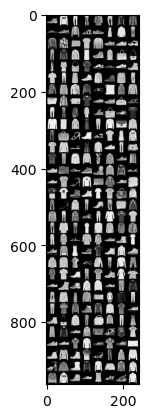

In [3]:
# Do not change this cell
dataiter = iter(test_loader)
images, labels = next(dataiter)
# Show images
imshow(torchvision.utils.make_grid(images))

In [4]:
# TODO: you will design your model here
class ConvModel(nn.Module):
    def __init__(self, input_size, output_size):
        # TODO: complete this method
        super().__init__()

        #this is the order of the steps for the convolutional neural net:
        self.steps = nn.Sequential(
            nn.Conv2d(input_size, 10, kernel_size=3, padding=1),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(10, 40, kernel_size=3),
            nn.BatchNorm2d(40),
            nn.ReLU(),
            nn.AvgPool2d(2),

            #fully connected:
            nn.Flatten(),
            nn.Linear(40*6*6, 100),
            nn.ReLU(),

            nn.Linear(100, 50),
            nn.ReLU(),

            #I got a little bit better result useing Tanh here:
            nn.Linear(50, 20),
            nn.Tanh(),
            
            nn.Linear(20, output_size), 
            #The cross entropy method includes the softmax: This is here if I need to try another loss function:
            # nn.LogSoftmax(dim=1),
        )


    def forward(self, x):
        # TODO: complete this method
        return self.steps(x)

In [5]:
def train_step(model, train_loader, loss_fn, optimizer, reg_param, device):
    # TODO: implement one epoch of training

    #send model to gpu
    model.to(device)

    #put model in training mode
    model.train()
    
    correct = 0
    total_len = 0
    train_loss = 0
    #train the model for each batch:
    for X_train, y_train in train_loader:
        #same as simple model here:
        X_train, y_train = X_train.to(device), y_train.to(device)
        #run a forward pass: 
        y_logit = model(X_train)
        y_predict = torch.argmax(y_logit, dim=1)

        #compute loss:
        prediction_loss = loss_fn(y_logit, y_train).item()
        #L2 norm
        l2 = 0
        for param in model.parameters():
            l2 += torch.norm(param)
        #plug into function
        train_loss += (prediction_loss + reg_param * l2).item()

        #for the backward pass -> it doesnt work with an item 
        loss = loss_fn(y_logit, y_train) + reg_param * l2

        #compute accuracy:
        correct += torch.eq(y_predict, y_train).sum().item()
        total_len += len(y_train)
    
        #backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_accuracy = (correct / total_len) * 100
    return train_loss/total_len, train_accuracy

In [6]:
def evaluation_step(model, data_loader, loss_fn, reg_param, device):
    # TODO: implement evaluation on a data set, data_loader 
    
    #same as above, but in inference mode and no need to optimize:
    
    #put model in inference mode
    model.eval()
    
    data_loss = 0
    correct = 0
    total_len = 0
    #train the model for each batch:
    for X_test, y_test in data_loader:
        #same as simple model here:
        X_test, y_test = X_test.to(device), y_test.to(device)
       
        with torch.inference_mode():
            #run a forward pass: 
            y_logit = model(X_test)
            y_predict = torch.argmax(y_logit, dim=1)
    
            #compute loss:
            prediction_loss = loss_fn(y_logit, y_test).item()
            #l2 Norm
            l2 = 0
            for param in model.parameters():
                l2 += torch.norm(param)
            #plug into function
            data_loss += (prediction_loss + reg_param * l2).item()

            #compute accuracy:
            correct += torch.eq(y_predict, y_test).sum().item()
            total_len += len(y_test)
            
    data_accuracy = (correct / total_len) * 100
    #I do the average loss here and above, because if I just do the total, the proportion of the eval and train will be all out of wack because of the sizes of data
    return data_loss/total_len, data_accuracy

In [7]:
def train_conv_model(train_loader, valid_loader, test_loader, random_seed):
    # Make device
    device = "gpu"
    if torch.cuda.is_available():
        device = "cuda"
    else:
        if torch.backends.mps.is_available():
            device = "mps"

    torch.manual_seed(random_seed)  # do not change this
    
    #create instance of model:
    model = ConvModel(1, 10).to(device)
    #set hyperperameters:
    n_epoch = 40
    learning_rate=.001
    reg_param = .005
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    #create arrays for tracking values:
    train_losses = np.zeros(n_epoch)   
    train_accuracies = np.zeros(n_epoch)
    
    valid_losses = np.zeros(n_epoch)
    valid_accuracies = np.zeros(n_epoch)

    test_losses = np.zeros(n_epoch)
    test_accuracies = np.zeros(n_epoch)


    for epoch in range(n_epoch):
        
        train_l, train_a = train_step(model, train_loader, loss_fn, optimizer, reg_param, device)
        validation_l, validation_a = evaluation_step(model, valid_loader, loss_fn, reg_param, device)
        test_l, test_a = evaluation_step(model, test_loader, loss_fn, reg_param, device)
        
        if epoch % 5 == 0:
            print("Epoch:")
            print(epoch)
            print('Training')
            print(train_l, train_a)
            print('Validation')
            print(validation_l, validation_a)
            print('Test')
            print(test_l, test_a)
        
        train_losses[epoch] = train_l
        train_accuracies[epoch] = train_a

        valid_losses[epoch] = validation_l
        valid_accuracies[epoch] = validation_a

        test_losses[epoch] = test_l
        test_accuracies[epoch] = test_a
    
    return model, train_losses, train_accuracies, valid_losses, valid_accuracies, test_losses, test_accuracies

In [8]:
def plot_accuracy_performance(train_accuracies, valid_accuracies, test_accuracies):
   # TODO: plot accuracy curves, you can reuse your codes from the simple classification task
    data = {'train': train_accuracies, 'test': test_accuracies, 'valid': valid_accuracies}
    accuracies = pd.DataFrame(data=data)
    sns.lineplot(data=accuracies)
    plt.title(f"Overall Accuracy Curve \n Max Test: {np.round(max(accuracies['test']), 5)}% at epoch {accuracies[['test']].idxmax().item()}\n Max Validation: {np.round(max(accuracies['valid']), 5)}% at epoch {accuracies[['valid']].idxmax().item()}")
    plt.xlabel("Epoch #")
    plt.ylabel("% Correctly Classified")

In [9]:
def plot_loss_performance(train_losses, valid_loss, test_losses):
# TODO: plot loss curves, you can reuse your codes from the simple classification task
    data = {'train': train_losses, 'test': test_losses, 'valid': valid_losses}
    losses = pd.DataFrame(data=data)
    sns.lineplot(data=losses)
    plt.title(f"Average L2 Regularized Loss using Cross Entropy\n Min Validation loss: {np.round(min(losses['valid']), 5)} at epoch: {losses[['valid']].idxmin().item()} \n Min Test loss: {np.round(min(losses['test']), 5)} at epoch {losses[['test']].idxmin().item()}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

In [10]:
# Do not change this cell
random_seed = 1
model, train_losses, train_accuracies, valid_losses, valid_accuracies, test_losses, test_accuracies\
= train_conv_model(train_loader, valid_loader, test_loader, random_seed)

Epoch:
0
Training
0.004260845760504404 75.18333333333334
Validation
0.002702248920996984 85.26666666666667
Test
0.0027905660629272463 84.7
Epoch:
5
Training
0.001677820285782218 91.63958333333333
Validation
0.0017787463242808978 90.35833333333333
Test
0.0018977833837270737 90.02
Epoch:
10
Training
0.0014740548046926658 93.53958333333333
Validation
0.001679269293944041 91.77499999999999
Test
0.001812819093465805 90.72
Epoch:
15
Training
0.0013699393893281619 94.57916666666667
Validation
0.0017057099267840385 91.55833333333334
Test
0.001822653529047966 90.69
Epoch:
20
Training
0.0012724013160914183 95.75625
Validation
0.001691737746198972 91.875
Test
0.001795104369521141 91.39
Epoch:
25
Training
0.001216546836619576 96.38333333333333
Validation
0.0017922252590457598 91.7
Test
0.0019283899009227754 90.79
Epoch:
30
Training
0.0011637511511022845 97.03958333333334
Validation
0.001815069337685903 91.90833333333333
Test
0.0019435549914836885 91.32000000000001
Epoch:
35
Training
0.001106787487

In [11]:
import pandas as pd
import seaborn as sns

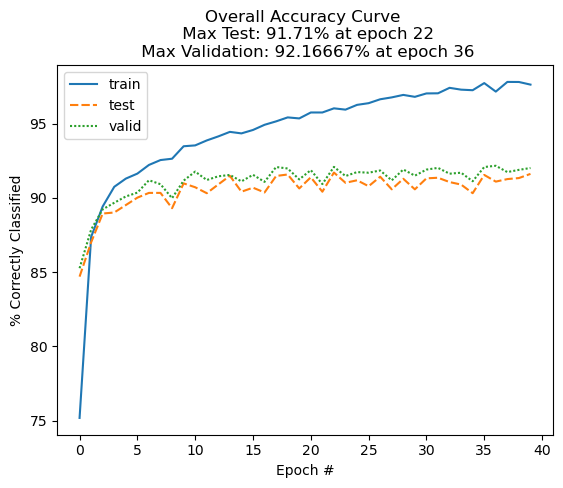

In [12]:
# Do not change this cell
plot_accuracy_performance(train_accuracies, valid_accuracies, test_accuracies)

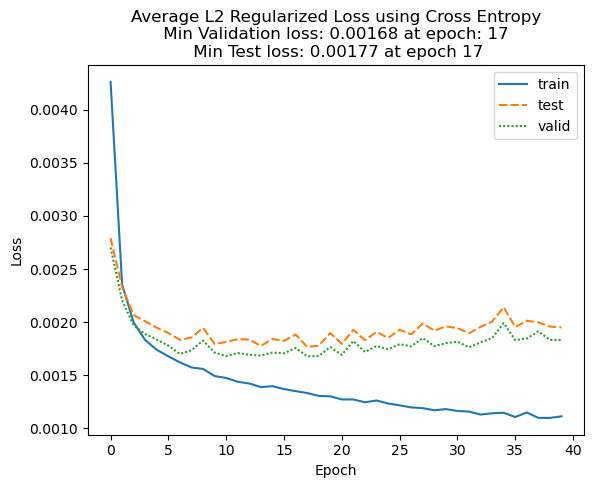

In [13]:
# Do not change this cell
plot_loss_performance(train_losses, valid_losses, test_losses)

In [14]:
#Citations: In addition to her example and the class slides
# ADAM weight decay L2: https://arxiv.org/abs/1412.6980

# Conv2D: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

# Flatten size: https://stackoverflow.com/questions/52474439/how-can-i-specify-the-flatten-layer-input-size-after-many-conv-layers-in-pytorch

# BatchNorm: https://discuss.pytorch.org/t/example-on-how-to-use-batch-norm/216